In [61]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from scipy.optimize import fsolve, minimize
import numpy as np
#import autograd.numpy as np
import math
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import pandas as pd
import csv
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate
#from pmapper.pharmacophore import Pharmacophore as P
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdmolops
#from pmapper.utils import load_multi_conf_mol
import smogn
import pubchempy as pcp

In [2]:
df_1 = pd.read_csv('compound_rejections.csv')
df_2 = pd.read_csv('smiles_2.csv')

In [3]:
df_1

,ID,Type of MB,Compound abbreviation,Types of contaminants,pH,Compound Mw (g/mol),Compound charge,Compound Kow,min projection (A),max projection (A),...,Total charge,Pressure (kPa),Measurement time (min),Initial concentration of compound (mg/L),compound size (nm),removal rate (%),reference,MWCO ref,MB contact angle ref,MB zeta potential ref
0,1,AK,22BET,2-(2-Butoxyethoxy)ethanol,7.0,162.229,0.0000,0.711,3.25,8.08,...,0.0000,800.0,10.0,0.16223,0.512,81.5900,Removal of organic contaminants by RO and NF m...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...
1,2,AK,CPL,Caprolactam,7.0,113.160,0.0000,0.310,3.92,4.01,...,0.0000,800.0,10.0,0.11316,0.396,82.8500,Removal of organic contaminants by RO and NF m...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...
2,3,AK,CTN,Creatine,7.0,131.135,0.0000,-2.864,3.35,4.36,...,0.0000,800.0,10.0,0.13114,0.382,96.6500,Removal of organic contaminants by RO and NF m...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...
3,4,AK,FAH,Formaldehyde,7.0,30.026,0.0000,-0.467,2.08,2.34,...,0.0000,800.0,10.0,0.03003,0.221,3.3500,Removal of organic contaminants by RO and NF m...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...
4,5,AK,IPP,Isopropanol,7.0,60.096,0.0000,0.255,2.95,3.36,...,0.0000,800.0,10.0,0.06010,0.315,65.2700,Removal of organic contaminants by RO and NF m...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...,Artificial neural network models based on QSAR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,1903,ESPA1,IDM,Indomethacin,7.0,357.790,-1.0000,3.530,5.24,8.54,...,1.0000,500.0,1440.0,0.02000,0.669,97.0719,Role of membrane and compound properties in af...,NaN,NaN,NaN
1902,1904,ESPA1,CPH,Cephalexin hydrate,7.0,347.390,-0.3711,-2.142,4.74,6.38,...,0.3711,500.0,1440.0,0.02000,0.550,95.2613,Role of membrane and compound properties in af...,NaN,NaN,NaN
1903,1905,ESPA1,DTZ,Diltiazem,7.0,414.520,0.9374,2.727,6.13,8.50,...,-0.9374,500.0,1440.0,0.02000,0.722,98.3872,Role of membrane and compound properties in af...,NaN,NaN,NaN
1904,1906,ESPA1,ETM,Erythromycin,7.0,733.937,1.0000,2.596,6.83,9.32,...,-1.0000,500.0,1440.0,0.02000,0.798,94.7621,Role of membrane and compound properties in af...,NaN,NaN,NaN


In [4]:
# decapitalize
# remove space

list_1 = df_1['Types of contaminants'].str.lower()
list_2 = df_2['Compound'].str.lower()
# a = pd.concat([df_2['Compound'], df_2['SMILES']], keys=['Compound', 'SMILES'])
# a['Compound'] = a['Compound'].str.lower()
list_1 = list_1.str.replace(' ', '')
list_2 = list_2.str.replace(' ', '')
list_1 = list_1.str.replace('-', '')
list_2 = list_2.str.replace('-', '')
list_1 = list_1.unique()
list_2 = list_2.unique()

In [5]:
df_2['Compound'] = df_2['Compound'].str.lower()
df_2['Compound'] = df_2['Compound'].str.replace(' ', '')
df_2['Compound'] = df_2['Compound'].str.replace('-', '')
df_2 = df_2.set_index('Compound')

In [6]:
df_2['SMILES'].loc['naproxen']

'COc1ccc2cc([C@H](C)C(=O)O)ccc2c1'

In [7]:
dicts = {}

for i in range(len(list_2)):
    for j in range(len(list_1)):
        if list_2[i] == list_1[j]:
            dicts[list_1[j]] = df_2['SMILES'].loc[list_1[j]]

In [8]:
list_1 = pd.DataFrame(list_1)

In [9]:
none_list = pd.DataFrame(['none']*len(list_1))

In [10]:
new_list = pd.concat([list_1, none_list], axis=1)
new_list.columns = ['compound', 'SMILES']

In [11]:
new_list

,compound,SMILES
0,2(2butoxyethoxy)ethanol,none
1,caprolactam,none
2,creatine,none
3,formaldehyde,none
4,isopropanol,none
...,...,...
225,ampicillin,none
226,cephalexinhydrate,none
227,diltiazem,none
228,erythromycin,none


In [12]:
for key in dicts:
    for i in range(len(new_list)):
        if new_list['compound'].iloc[i] == key:
            new_list['SMILES'].iloc[i] = dicts[key]
            
new_list.to_csv('new_list.csv')

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [16]:
from rdkit import DataStructs
ms = Chem.MolFromSmiles('CCOC') #[Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'), Chem.MolFromSmiles('COC')]
#fps = [Chem.RDKFingerprint(x) for x in ms]
fps = Chem.RDKFingerprint(ms, fpSize=1024)

fp1 = AllChem.GetMorganFingerprint(ms,2)
fp2 = AllChem.GetMorganFingerprintAsBitVect(ms,2,nBits=1024)

In [43]:
with open("output_test.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for element in a:
        wr.writerow([element])
    output.close()

In [46]:
# 3d
# https://iwatobipen.wordpress.com/2015/07/09/calculate-3d-pharmacophore-fingerprint-in-rdkit/
m = Chem.MolFromSmiles('OCC=CC(=O)O')
AllChem.EmbedMolecule(m)
fp = Generate.Gen2DFingerprint(m, Gobbi_Pharm2D.factory, dMat=Chem.Get3DDistanceMatrix(m))


In [69]:
mol = Chem.MolFromSmiles('C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O')  # talidomide

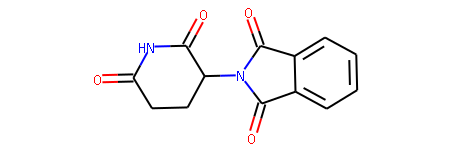

In [70]:
mol

In [71]:
mol = Chem.AddHs(mol)

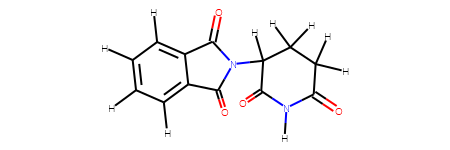

In [72]:
mol

In [86]:
# https://github.com/DrrDom/pmapper

mol = Chem.MolFromSmiles('C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O')  # talidomide
mol = Chem.AddHs(mol)
#AllChem.EmbedMolecule(mol, randomSeed=42)
AllChem.EmbedMultipleConfs(mol, numConfs=10, randomSeed=1024)

In [90]:
p = P()
#p.load_from_mol(mol)
ps = load_multi_conf_mol(mol)

In [92]:
b = p.get_fp(min_features=4, max_features=4)   # set of activated bits
print(b)

set()


In [83]:
arr = np.zeros((1, 2048))
arr = arr.astype('int')
df_arr = pd.DataFrame(arr)

In [84]:
temp = p.get_fp(min_features=4, max_features=4, nbits=2048, activate_bits=2)
temp = list(temp)

In [85]:
for i in zip(temp):
    df_arr.iloc[0][i[0]] = 1

In [7]:
mol = Chem.MolFromSmiles('CC(O)C(O)(O)C')
generator = rdFingerprintGenerator.GetAtomPairGenerator()
fp = generator.GetSparseCountFingerprint(mol)
non_zero = fp.GetNonzeroElements()
print(non_zero)

{541731: 1, 574497: 1, 574498: 1, 590881: 1, 590882: 1, 590945: 1, 1590306: 3, 1590307: 3, 1590369: 1, 1590370: 2, 1590401: 2, 1590402: 1, 1592354: 1, 1592355: 2}


In [32]:
fp = Pairs.GetAtomPairFingerprintAsBitVect(mol)

In [33]:
fp

In [35]:
bitstr = fp.ToBitString()

In [37]:
len(bitstr)

8388608

In [5]:

fp = rdmolops.RDKFingerprint(mol, fpSize=2048, minPath=1, maxPath=7).ToBitString()

print(fp)

0000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000100000000000000000000100000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000001000000000000000000000000000000000000000000100000000000000001000000000001000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000001001000000000000100000000000000000000000

In [18]:
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
 
mol = Chem.MolFromSmiles( 'O=C2C(Cc1ccc(cc1)C(C(=O)O)C)CCC2' )
AllChem.EmbedMolecule( mol ) #gen 3d
 
factory = Gobbi_Pharm2D.factory
#calc 3d p4 fp
fp = Generate.Gen2DFingerprint(mol, factory, dMat = Chem.Get3DDistanceMatrix(mol))

In [20]:
bitstr = fp.ToBitString()

In [22]:
len(bitstr)

39972

In [5]:
# MACCS Keys
ms = Chem.MolFromSmiles('CCOC')
fps = MACCSkeys.GenMACCSKeys(ms)

In [10]:
bitstr = fps.ToBitString() 
print(bitstr)

00000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000010000000000000001000011000000000010000000000000000000000100010101001000100


In [24]:
from base64 import b64decode

def PCFP_BitString(pcfp_base64) :

    pcfp_bitstring = "".join( ["{:08b}".format(x) for x in b64decode( pcfp_base64 )] )[32:913]
    return pcfp_bitstring

In [25]:
pcfps = 'AAADcYBgAAAAAAAAAAAAAAAAAAAAAAAAAAAwAAAAAAAAAAABAAAAGAAAAAAACACAEAAwAIAAAACAACBCAAACAAAgAAAIiAAAAIgIICKAERCAIAAggAAIiAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA=='

In [26]:
print(len(PCFP_BitString(pcfps)))
print(PCFP_BitString(pcfps))

881
10000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000001100000000000000000000000000000000000000000000000100000000000100000000001000000000000001100000000000010000000000000000000000000000000100000000000000000100000010000100000000000000000000000100000000000000000001000000000000000000000000010001000100000000000000000000000000010001000000010000010000000100010100000000001000100010000100000000010000000000000001000001000000000000000000010001000100000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [3]:
# PubChem keys
a = pcp.get_compounds('C1=CC2=C(C3=C(C=CC=N3)C=C2)N=C1', 'smiles')

In [21]:

bin(int(a[0].fingerprint, 16))

'0b1101110001110000000111001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011110001011000100000000000000000000000000000000000000000000000000000001011000111111110000000000000000000011100000000000000000000000000000000000000000000001100000010001100000100011110000001000011110011000000111100100000100000010000000000001010000000000011001101000110011101000100000000001000001010000000001001000011000100010010001000000000100011011000001000000011100001110100100110000000100001100000111000101100000010010001100100011001010000100000000010000110000010000000000000001100100011001000000001110001000010000000110000000000111001000000000000000000000001000000000000000000001000000000001000001000000000000000000000001000000000000000000001000000000001000000000000000000000000000000000000000000000000000000'

In [22]:
a[0].cactvs_fingerprint

'11000000011100110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111000101100010000000000000000000000000000000000000000000000000000000101100011111111000000000000000000001110000000000000000000000000000000000000000000000110000001000110000010001111000000100001111001100000011110010000010000001000000000000101000000000001100110100011001110100010000000000100000101000000000100100001100010001001000100000000010001101100000100000001110000111010010011000000010000110000011100010110000001001000110010001100101000010000000001000011000001000000000000000110010001100100000000111000100001000000011000000000011100100000000000000000000000100000000000000000000100000000000100000100000000000000000000000100000000000000000000100000000000100000000000000000000000000000000000000000000000'

In [15]:
ms = Chem.MolFromSmiles('CCOC')
GetAvalonFP(ms, nBits=2048)

## Part 2

In [11]:
df_smiles = pd.read_csv('new_list_2.csv', index_col='no')

In [12]:
# RDK fingerprint (daylight)
with open("output_test_2.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = Chem.RDKFingerprint(m, fpSize=32768, minPath=1, maxPath=3)
        bitstr = fp.ToBitString()
        onbits = list(fp.GetOnBits())[:]
        print(txt, onbits)
        wr.writerows([bitstr])
    
    output.close()

CCCCOCCOCCO [1339, 3975, 5404, 6265, 8085, 9964, 9970, 18112, 18994, 23237, 24341, 25020, 25694, 29547, 29855, 29905, 31028, 32680]
C1CCC(=O)NCC1 [166, 781, 1075, 1105, 3975, 5399, 5404, 8654, 9078, 9964, 10174, 11042, 11280, 12400, 13376, 14195, 14335, 15354, 15560, 19665, 20816, 21473, 22940, 23237, 23694, 24341, 29547, 32553]
CN(CC(=O)O)C(=N)N [43, 166, 719, 1075, 1105, 1339, 2812, 3087, 5235, 5248, 5404, 8742, 8958, 9964, 10174, 11045, 12400, 13172, 14195, 14335, 17464, 17830, 18112, 18994, 19665, 21005, 21473, 21737, 22381, 22940, 23681, 23694, 23986, 24768, 27518, 28400, 29855, 29913, 31649, 32553]
C=O [1075, 14195]
CC(C)O [1339, 5404, 8248, 9964, 18112, 18994, 23237, 24341, 24805, 29855]
CO [1339, 18994]
NC(N)=O [43, 1075, 1105, 5235, 8644, 11042, 11280, 14195, 14335, 25805]
CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O [1339, 1400, 2890, 3025, 3736, 3975, 4426, 4840, 4945, 5017, 5404, 6317, 6970, 7074, 7747, 8248, 9964, 11624, 11785, 12056, 12891, 13539, 13554, 14509, 15009, 15295, 

CCc1cccc(C)c1N(C(=O)CCl)C(C)COC [166, 786, 1042, 1075, 1105, 1270, 1339, 1771, 2890, 3025, 3087, 4426, 4707, 4840, 5404, 6265, 6970, 7074, 7106, 8085, 8654, 9078, 9964, 10174, 11042, 11095, 11158, 11239, 11280, 11410, 11473, 11624, 11785, 12056, 12400, 13338, 13376, 13539, 14029, 14195, 14335, 14413, 15354, 17370, 17375, 17532, 18054, 18064, 18092, 18112, 18614, 18985, 18994, 19005, 19492, 19557, 19665, 19928, 21005, 21473, 22763, 22940, 23237, 23694, 24302, 24341, 25694, 26360, 26367, 26918, 27005, 28533, 29855, 29905, 30881, 31028, 31574, 31746, 32064, 32179, 32553, 32680]
COC1=CC(=C(C=C1)C(=O)C2=CC=CC=C2)O [1075, 1339, 1400, 1805, 2890, 3025, 3116, 4426, 4431, 4840, 4945, 5017, 5378, 7074, 10310, 11324, 11785, 12056, 13086, 14195, 15295, 17466, 18994, 19192, 19492, 20019, 21860, 23482, 24620, 25499, 25947, 26274, 26360, 26918, 27673, 28533, 28914, 29518, 30014, 30881, 31574, 31746]
C1=CC(=CC=C1N)S(=O)(=O)NC2=NN=C(C=C2)Cl [247, 678, 786, 1270, 2363, 2890, 3108, 3675, 4098, 4342, 4426

CCC(C)O [1339, 3975, 5404, 8248, 9964, 18112, 18994, 23237, 24341, 24805, 25694, 29547, 29855, 29905]
CCCCO [1339, 3975, 5404, 9964, 18112, 18994, 23237, 24341, 25694, 29547, 29855, 29905]
C1=CC=C2C(=C1)C(=CN2)C[C@@H](C(=O)O)N [85, 498, 1075, 1105, 1339, 1861, 2890, 3025, 3087, 3108, 4257, 4426, 4780, 4840, 5404, 6886, 6970, 7074, 7761, 8958, 9964, 11473, 11624, 11785, 11896, 12056, 12293, 12400, 13539, 14195, 14335, 14336, 15560, 18064, 18112, 18994, 19170, 19459, 19492, 20816, 20826, 21005, 21305, 21473, 22381, 23237, 23681, 23694, 23986, 24341, 25694, 26360, 26918, 27257, 27547, 28400, 28533, 28843, 29855, 29905, 30881, 31558, 31574, 31649, 31746, 32064, 32553, 32635]
CC1=CC(=C(C=C1)C(C)C)O [1400, 1805, 2890, 3025, 4426, 4431, 4840, 4945, 5017, 5404, 6970, 7074, 9964, 11624, 11785, 12056, 13539, 15295, 19492, 20019, 21193, 22330, 23237, 23482, 24341, 25947, 26360, 26918, 28533, 30014, 30881, 31574, 31746, 32064]
OCCO [1339, 5404, 9964, 9970, 18112, 18994, 25020, 29855]
C(CO)CO [1339

In [14]:
# RDK fingerprint (path-based; max_path=7)
with open("output_test_2_path.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = rdmolops.RDKFingerprint(m, fpSize=4096, minPath=1, maxPath=2)
        onbits = list(fp.GetOnBits())[:]
        print(txt, onbits)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

CCCCOCCOCCO [1183, 1308, 1339, 1728, 1772, 2610, 2757, 3861, 3989, 4008]
C1CCC(=O)NCC1 [112, 166, 993, 1075, 1105, 1308, 1772, 1907, 2047, 2460, 2757, 2850, 3088, 3214, 3861, 3881]
CN(CC(=O)O)C(=N)N [43, 112, 166, 550, 766, 993, 1075, 1105, 1139, 1183, 1241, 1308, 1339, 1446, 1728, 1772, 1907, 2047, 2460, 2610, 2812, 2977, 3214, 3881]
C=O [1075, 1907]
CC(C)O [1183, 1308, 1339, 1728, 1772, 2610, 2757, 3861]
CO [1339, 2610]
NC(N)=O [43, 1075, 1105, 1139, 1907, 2047, 2850, 3088]
CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O [330, 519, 603, 744, 1183, 1308, 1339, 1342, 1371, 1400, 1728, 1772, 2342, 2610, 2757, 2874, 2890, 2978, 3007, 3074, 3108, 3208, 3432, 3736, 3861, 3957]
Oc1ccc(Cl)cc1 [262, 330, 1013, 1342, 1371, 1400, 1598, 2342, 2510, 2890, 3007, 3074]
CC(=O)NC1=CC=C(C=C1)O [112, 330, 786, 993, 1050, 1075, 1105, 1308, 1342, 1371, 1400, 1772, 1907, 2047, 2283, 2342, 2621, 2850, 2890, 3007, 3074, 3088, 3214, 3544, 3822, 3881]
CCNC1=NC(=NC(=N1)Cl)NC(C)C [5, 112, 116, 161, 786, 854, 1050, 110

OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO [1183, 1308, 1339, 1728, 1772, 2610, 2757, 3861]
C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3 [43, 112, 166, 330, 744, 798, 993, 1075, 1105, 1139, 1144, 1308, 1380, 1772, 1907, 2047, 2342, 2460, 2850, 2874, 2890, 2978, 3074, 3088, 3108, 3139, 3214, 3432, 3881, 3957]
CC(=O)NC1=C(C(=C(C(=C1I)C(=O)O)I)NC(=O)C)I [112, 155, 330, 744, 766, 786, 993, 1050, 1075, 1105, 1308, 1339, 1561, 1670, 1772, 1907, 2047, 2118, 2283, 2325, 2342, 2610, 2621, 2850, 2890, 2977, 2978, 3074, 3088, 3097, 3108, 3214, 3397, 3411, 3544, 3822, 3881, 3957]
O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl [112, 166, 330, 744, 786, 804, 993, 1075, 1105, 1183, 1201, 1207, 1308, 1339, 1465, 1511, 1708, 1728, 1772, 1791, 1907, 1939, 2047, 2203, 2325, 2342, 2460, 2610, 2621, 2757, 2790, 2850, 2874, 2890, 2977, 2978, 3010, 3074, 3088, 3108, 3214, 3218, 3411, 3432, 3544, 3734, 3822, 3850, 3861, 3881, 3887, 3957]
C1=CC=C2C(=C1)C=C3C=CC=CC3=C2C(=O)O [330, 744, 766, 1075, 1339, 1907, 2118, 2325,

In [29]:
# morgan (circular) fingerprint

with open("output_test_2_morgan.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        bi = {}
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=1, nBits=4096, bitInfo=bi) # radius = 2, 4, 6 <-
        onbits = list(fp.GetOnBits())[:]
        print(txt, onbits)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

CCCCOCCOCCO [13, 695, 807, 2128, 2270, 2342, 2521, 2842, 3105, 3959, 4040]
C1CCC(=O)NCC1 [1028, 1380, 1575, 2353, 2362, 2698, 2974, 3162, 3786, 3914]
CN(CC(=O)O)C(=N)N [140, 807, 1163, 1190, 1737, 1917, 2128, 2351, 2382, 2437, 2671, 2698, 2855, 2929, 3105, 3152, 3219]
C=O [1366, 2380, 2698]
CC(C)O [709, 807, 2049, 2275, 2331, 3105]
CO [807, 1155, 3105]
NC(N)=O [140, 1917, 2458, 2698, 2855, 3219]
CC12CCC3C(C1CCC2(C#C)O)CCC4=C3C=CC(=C4)O [519, 622, 807, 875, 909, 1027, 1154, 1162, 1236, 1274, 1325, 1380, 1436, 2503, 2722, 2793, 2963, 2974, 3022, 3067, 3105, 3108, 3147, 3650, 3786, 3798, 3921]
Oc1ccc(Cl)cc1 [216, 561, 807, 1380, 1683, 2793, 3650, 3798, 3921]
CC(=O)NC1=CC=C(C=C1)O [191, 245, 807, 1380, 1917, 2698, 2793, 2855, 3065, 3105, 3200, 3650, 3798, 3864, 3921]
CCNC1=NC(=NC(=N1)Cl)NC(C)C [378, 561, 690, 1380, 1582, 1683, 1855, 2049, 2128, 2331, 2342, 3076, 3105, 3200, 3385, 3464, 3774]
Cn1c(=O)c2c(ncn2C)n(C)c1=O [378, 564, 771, 932, 1145, 1380, 1696, 2362, 2552, 2698, 2983, 3105, 345

In [40]:
# Pharm2D (chemical feature and distance) fingerprint

with open("output_test_2_pharm.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = Generate.Gen2DFingerprint(m, Gobbi_Pharm2D.factory)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [106]:
# Pharm3D with Pmapper

with open("output_test_2_pharm.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        mh =Chem.AddHs(m)
        AllChem.EmbedMolecule(mh, randomSeed=42)
        p = P()
        p.load_from_mol(mh)
        temp = p.get_fp(min_features=4, max_features=4, nbits=2048, activate_bits=1)
        temp = list(temp)
        
        arr = np.zeros((1, 2048))
        arr = arr.astype('int')
        df_arr = pd.DataFrame(arr)
        
        for j in zip(temp):
            df_arr.iloc[0][j[0]-1] = 1
        
        wr.writerows([df_arr.iloc[0][:]])
    
    output.close()

In [63]:
# MACCS fingerprint 
with open("output_test_2_MACCS.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = MACCSkeys.GenMACCSKeys(m)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [71]:
# PubChem fingerprint 
with open("output_test_2_PubChem.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = pcp.get_compounds(txt, 'smiles')
        bitstr = m[0].cactvs_fingerprint #bin(int(m[0].fingerprint, 16))
        #m = Chem.MolFromSmiles(txt)
        #fp = MACCSkeys.GenMACCSKeys(m)
        #bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [79]:
# Avalon fingerprint 
# https://www.moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/
with open("output_test_2_Avalon.csv", 'w', newline= '') as output:
    wr = csv.writer(output, dialect='excel')
    for i in range(len(df_smiles)):
        txt = df_smiles['SMILES'].iloc[i]
        m = Chem.MolFromSmiles(txt)
        fp = GetAvalonFP(m, nBits=2048)
        bitstr = fp.ToBitString()
        wr.writerows([bitstr])
    
    output.close()

In [22]:
df_temp = pd.read_csv('output_test_2_morgan.csv', header=None)

In [23]:
df_temp.insert(0, column='0', value=df_smiles['compound'])

In [24]:
df_temp.columns = range(df_temp.columns.size)

In [16]:
# #df_temp = pd.read_csv('output_test_3.csv', header=None)
# df_temp = pd.read_csv('output_test_3_morgan.csv', header=None)

In [4]:
df_rej.to_csv('compound_rejections_3_temp.csv')

In [3]:
df_rej = pd.read_csv('compound_rejections_3.csv', encoding='windows-1252')

df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.lower()
df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.replace(' ', '')
df_rej['Types of contaminants'] = df_rej['Types of contaminants'].str.replace('-', '')

In [26]:
# df_rej.drop(labels=['ID', 'Compound abbreviation', 'Compound Mw (g/mol)', 'Compound charge', 'Compound Kow', 'min projection (A)', 
#                     'max projection (A)', 'Measurement time (min)', 'Pressure (kPa)', 'Initial concentration of compound (mg/L)', 'MB zeta potential',
#                     'compound size (nm)', 'Total charge', 'reference', 'MWCO ref', 'MB contact angle ref', 'MB zeta potential ref'], axis=1, inplace=True)

df_rej.drop(labels=['ID', 'Compound abbreviation', 'Compound Mw (g/mol)', 'Compound charge', 'Compound Kow', 'min projection (A)', 
                    'max projection (A)', 'MB zeta potential', 'mem_material',
                    'compound size (nm)', 'Total charge', 'reference', 'MWCO ref', 'MB contact angle ref', 'MB zeta potential ref'], axis=1, inplace=True)

df_rej    

,Type of MB,Types of contaminants,pH,MB MWCO (Da),MB contact angle,Pressure (kPa),Measurement time (min),Initial concentration of compound (mg/L),removal rate (%)
0,AK,2(2butoxyethoxy)ethanol,7.0,150,50.0,800.0,10.0,0.16223,81.59
1,AK,caprolactam,7.0,150,50.0,800.0,10.0,0.11316,82.85
2,AK,creatine,7.0,150,50.0,800.0,10.0,0.13114,96.65
3,AK,formaldehyde,7.0,150,50.0,800.0,10.0,0.03003,3.35
4,AK,isopropanol,7.0,150,50.0,800.0,10.0,0.06010,65.27
...,...,...,...,...,...,...,...,...,...
1901,XLE440,trichloroethylene,8.0,150,39.8,410.0,2880.0,0.10000,3.00
1902,XLE440,chloroform,8.0,150,39.8,410.0,10.0,0.10000,10.00
1903,XLE440,carbontetrachloride,8.0,150,39.8,410.0,10.0,0.10000,69.00
1904,XLE440,perchloroethylene,8.0,150,39.8,410.0,10.0,0.10000,71.00


In [34]:
df_rej.to_csv('rejection_name_check.csv')

In [35]:
df_rej.describe()

,pH,MB MWCO (Da),MB contact angle,removal rate (%)
count,1906.000000,1906.000000,1906.000000,1906.000000
mean,6.611647,193.015740,51.622959,78.521072
std,1.614833,96.942301,15.359779,26.624313
min,2.200000,65.000000,14.400000,0.000000
25%,7.000000,100.000000,41.400000,72.062500
50%,7.000000,152.000000,53.800000,90.820000
75%,7.000000,300.000000,63.200000,96.900000
max,11.000000,460.000000,79.400000,100.000000


In [18]:
# split the data on test and training first, then perform SMOTE just on the training part, and then test the algorithm on the part of the dataset that doesn't have synthetic examples
# https://stackoverflow.com/questions/31856326/smote-oversampling-and-cross-validation

df_rej_smogn = smogn.smoter(data = df_rej, y = "removal rate (%)", samp_method='extreme')

C:\Users\leesa\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
r_index: 100%|######################################################################| 352/352 [00:00<00:00, 428.01it/s]


In [19]:
df_rej_smogn.describe()

,pH,MB MWCO (Da),MB contact angle,MB zeta potential,Pressure (kPa),Initial concentration of compound (mg/L),removal rate (%)
count,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000,2588.000000
mean,6.598259,216.355487,51.641074,-0.495769,755.424949,32.500318,55.451203
std,1.600463,97.941845,15.137272,0.569333,391.900119,210.049310,32.965072
min,2.200000,60.000000,14.400000,-1.000000,230.131088,0.000000,0.000000
25%,6.962516,118.000000,41.400000,-1.000000,496.524945,0.025570,25.583055
50%,7.000000,200.000000,51.751263,-1.000000,690.000000,0.650000,52.789613
75%,7.024878,310.000000,64.000000,0.000000,1000.000000,10.000000,91.117750
max,11.000000,463.000000,79.490915,1.015295,3000.000000,2003.462270,100.000000


(array([ 61.,  70.,  57.,  66.,  47.,  68.,  71., 175., 301., 990.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

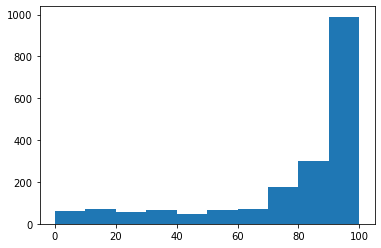

In [22]:
plt.hist(df_rej['removal rate (%)'])

(array([248., 254., 247., 251., 197., 261.,  97., 127., 211., 695.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

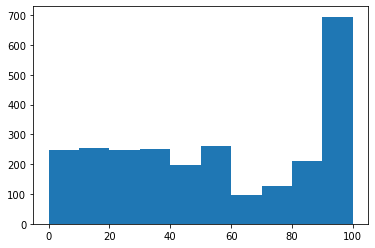

In [21]:
plt.hist(df_rej_smogn['removal rate (%)'])

In [24]:
#results = df_rej.iloc[0].append(df_temp_morgan.loc[0][1:])

In [25]:
#df_results = pd.DataFrame(results)

In [26]:
#transposed = df_results.transpose()

In [29]:
#result = pd.concat([df_rej.iloc[0], df_temp_morgan.loc[0][1:]], axis=0)

In [30]:
#df_result = pd.DataFrame(result)

In [31]:
#transposed = result.transpose()

In [27]:
df_fin = pd.DataFrame()

for i in range(len(df_rej)):
    print(i)
    c = df_rej['Types of contaminants'].iloc[i]
    for j in range(len(df_temp)):
        if c == df_temp[0].iloc[j]:
            result = pd.concat([df_rej.iloc[i], df_temp.loc[j][1:]], axis=0)
            df_result = pd.DataFrame(result)
            transposed = df_result.transpose()
            df_fin = pd.concat([df_fin, transposed], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905


In [22]:
df_fin = pd.DataFrame()

for i in range(len(df_rej_smogn)):
    c = df_rej_smogn['Types of contaminants'].iloc[i]
    for j in range(len(df_temp)):
        if c == df_temp[0].iloc[j]:
            result = pd.concat([df_rej_smogn.iloc[i], df_temp.loc[j][1:]], axis=0)
            df_result = pd.DataFrame(result)
            transposed = df_result.transpose()
            df_fin = pd.concat([df_fin, transposed], axis = 0)

In [28]:
#df_fin.to_csv('df_fin_path_32768_3_fin.csv', index=False)
#df_fin.to_csv('df_fin_MACCS_smogn_ex.csv')
#df_fin.to_csv('df_fin_MACCS_short.csv')
df_fin.to_csv('df_fin_morgan_16384_3_fin.csv', index=False)
#df_fin.to_csv('df_fin_morgan_2048_6_new.csv', index=False)

In [4]:
# PubChem 881
df_2 = pd.read_csv('df_fin_PubChem_new.csv')

In [5]:
df_2

,Type of MB,Types of contaminants,pH,MB MWCO (Da),MB contact angle,Pressure (kPa),Measurement time (min),Initial concentration of compound (mg/L),removal rate (%),1,...,872,873,874,875,876,877,878,879,880,881
0,AK,2(2butoxyethoxy)ethanol,7.0,150,50.0,800.0,10.0,0.16223,81.59,1,...,0,0,0,0,0,0,0,0,0,0
1,AK,caprolactam,7.0,150,50.0,800.0,10.0,0.11316,82.85,1,...,0,0,0,0,0,0,0,0,0,0
2,AK,creatine,7.0,150,50.0,800.0,10.0,0.13114,96.65,1,...,0,0,0,0,0,0,0,0,0,0
3,AK,formaldehyde,7.0,150,50.0,800.0,10.0,0.03003,3.35,0,...,0,0,0,0,0,0,0,0,0,0
4,AK,isopropanol,7.0,150,50.0,800.0,10.0,0.06010,65.27,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,XLE440,trichloroethylene,8.0,150,39.8,410.0,2880.0,0.10000,3.00,0,...,0,0,0,0,0,0,0,0,0,0
1902,XLE440,chloroform,8.0,150,39.8,410.0,10.0,0.10000,10.00,0,...,0,0,0,0,0,0,0,0,0,0
1903,XLE440,carbontetrachloride,8.0,150,39.8,410.0,10.0,0.10000,69.00,0,...,0,0,0,0,0,0,0,0,0,0
1904,XLE440,perchloroethylene,8.0,150,39.8,410.0,10.0,0.10000,71.00,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
txt = 'removal rate (%)'

print(df_2[txt].quantile(0.25), df_2[txt].quantile(0.5), df_2[txt].quantile(0.75))
print(df_2[txt].min(), df_2[txt].max())

72.0625 90.82 96.9
0.0 100.0


In [9]:
df_2['pH'].min()

2.2